[Table of contents](../toc.ipynb)

# A machine learning model of a electric vehicle power train

The steps herein are similar to a recent paper of mine [[Rhode2020]](../references.bib), were online machine learning was used to create a power prediction model for an electric vehicle.

## Vehicle black box model

<img src="e-vehicle-model.png" alt="e-vehicle-model" width="400" align="right">

The right hand side figure illustrates the adopted non-linear black-box vehicle model,
$p_t \approx f(v_t, {a_x}_t)$

which includes two measured inputs, the velocity ($v_t$) and longitudinal acceleration ($a_x$), and the measured output power ($p$), being the product of the measured electric current and voltage. Our objective is to approximate the unknown non-linear function $f(\cdot)$ of the model equation given the measurements $v_t, {a_x}_t$, and $p_t$.

Note that the body fixed acceleration sensor considers road angle influence.

The instantaneous tractive force reads

$
F_{t} = m_V \dot{v_{t}} + f_r m_V g \cos \theta_{t} + m_V g \sin \theta_{t} + \frac{\rho}{2} c_w A_V v_t^2,
$

and the instantaneous power
$
p_t = F_t v_t.
$

## Kernel adaptive filter

<img src="adaptive-filter.png" alt="adaptive filter" width="400" align="right">

## Data record

The electric vehicle was propelled by two electric engines and their current and voltage was recorded at 100 Hz. Additionally, longitudinal acceleration and velocity from CAN bus signals as well as break pressure form disc brakes were stored.

All raw signals were smoothed with a Savitzky-Golay filter (window size 50) and down-sampled to 2 Hz.

Additionally, driving states with break pressure > 0 were removed from data because the black box model does not consider mechanical braking.

In [1]:
import scipy.io
mat = scipy.io.loadmat('dat1.mat')

In [8]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A', 'Aval', 'B', 'Bval', 'k', 'm'])

In [9]:
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

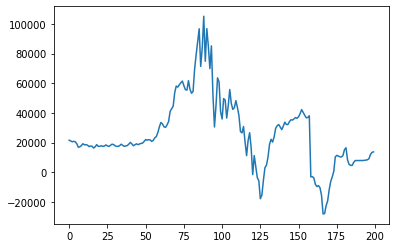

In [12]:
plt.plot(mat["Bval"])